In [3]:
import pandas as pd

In [4]:
df_fraudes=pd.read_csv('C:/Users/Héctor/OneDrive/Data Scientist/Proyecto_portafolio/proyecto-portafolio/Data/card_transdata.csv',delimiter=',')

In [5]:
df_fraudes.head(10)

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0
5,5.586408,13.261073,0.064768,1.0,0.0,0.0,0.0,0.0
6,3.724019,0.956838,0.278465,1.0,0.0,0.0,1.0,0.0
7,4.848247,0.320735,1.273050,1.0,0.0,1.0,0.0,0.0
8,0.876632,2.503609,1.516999,0.0,0.0,0.0,0.0,0.0
9,8.839047,2.970512,2.361683,1.0,0.0,0.0,1.0,0.0


In [17]:
create_report(df_fraudes).show_browser()

 50%|##############################################                                              | 1/2 [00:00<…

 50%|##############################################                                              | 1/2 [00:00<…

 50%|##############################################                                              | 1/2 [00:00<…

 50%|##############################################                                              | 1/2 [00:00<…

100%|############################################################################################| 1/1 [00:00<…

100%|############################################################################################| 1/1 [00:00<…

  0%|                                                                                         | 0/1052 [00:00<…

C:\ProgramData\anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\ProgramData\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:5283: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


In [6]:
#Cuantos renglones y columnas tiene
df_fraudes.shape

(1000000, 8)

In [7]:
#Tiene missings, minimos, maximos, medias, desviación estandar
df_fraudes.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
#Cuantos ceros y unos hay para las variables binarias
#importar libreria de matplotlib
import matplotlib.pyplot as plt

In [9]:
#Agrupando datos por genero y contando
df_f=df_fraudes[['fraud', 'used_chip']]
df_f_count=df_f.groupby(['fraud']).count()
df_f_count=df_f_count.rename(columns={'used_chip':'count'})
df_f_count

,count
fraud,
0.0,912597
1.0,87403


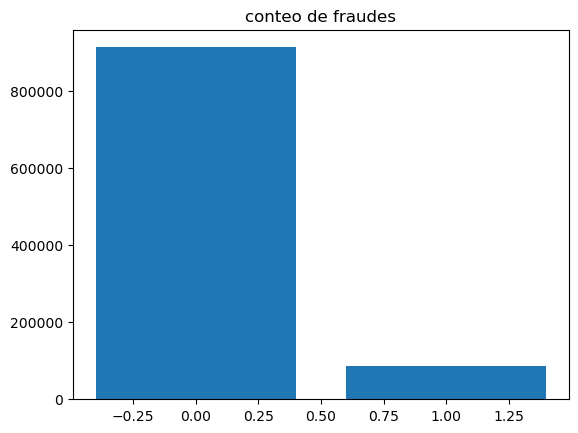

In [10]:
#hacer conteo por edad
plt.bar(df_f_count.index, df_f_count['count'])
plt.title('conteo de fraudes')
plt.show()

In [11]:
import seaborn as sb

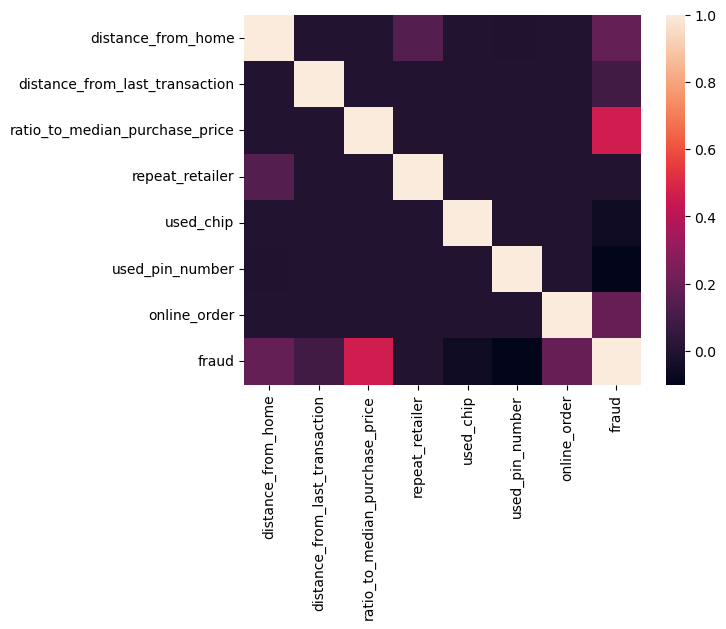

In [12]:
# graficando las correlaciones
dataplot=sb.heatmap(df_fraudes.corr())
  
# mostrando el mapa de calor
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

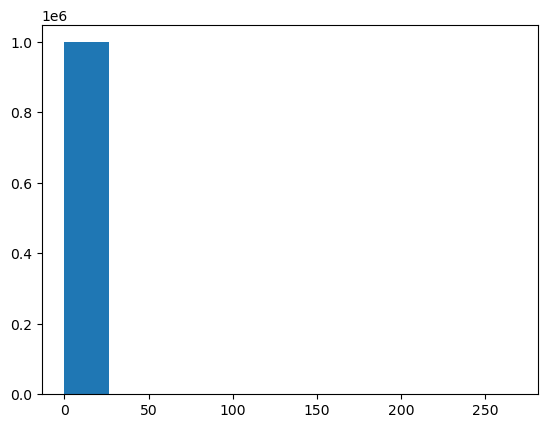

In [13]:
#El ratio es importante por que esta muy correlacionado a la variable de interes
#hacer histograma de edad
df_ratio=df_fraudes[['ratio_to_median_purchase_price', 'fraud']]
plt.hist(df_ratio['ratio_to_median_purchase_price'])
plt.show

In [46]:
#Crear deciles de la variable para que nos deje ver algo más
df_ratio['Rangos_ratio'] = pd.qcut(df_ratio['ratio_to_median_purchase_price'], q=10)
df_ratio.head()

C:\Users\Héctor\AppData\Local\Temp\ipykernel_9760\2614463904.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ratio['Rangos_ratio'] = pd.qcut(df_ratio['ratio_to_median_purchase_price'], q=10)


,ratio_to_median_purchase_price,fraud,Rangos_ratio
0,1.945940,0.0,"(1.778, 2.517]"
1,1.294219,0.0,"(0.998, 1.318]"
2,0.427715,0.0,"(0.396, 0.561]"
3,0.362663,0.0,"(0.244, 0.396]"
4,2.222767,0.0,"(1.778, 2.517]"


In [47]:
df_ratio_count=df_ratio.groupby(['Rangos_ratio','fraud']).count()
df_ratio_count

ratio_to_median_purchase_price
Rangos_ratio                   fraud                                
(0.0034000000000000002, 0.244] 0.0                             97511
                               1.0                              2489
(0.244, 0.396]                 0.0                             97487
                               1.0                              2513
(0.396, 0.561]                 0.0                             97438
                               1.0                              2562
(0.561, 0.756]                 0.0                             97485
                               1.0                              2515
(0.756, 0.998]                 0.0                             97532
                               1.0                              2468
(0.998, 1.318]                 0.0                             97435
                               1.0                              2565
(1.318, 1.778]                 0.0                             97592
                               1.0                              2408
(1.778, 2.517]                 0.0                             97507
                               1.0                              2493
(2.517, 4.081]                 0.0                             95610
                               1.0                              4390
(4.081, 267.803]               0.0                             37000
                               1.0                             63000

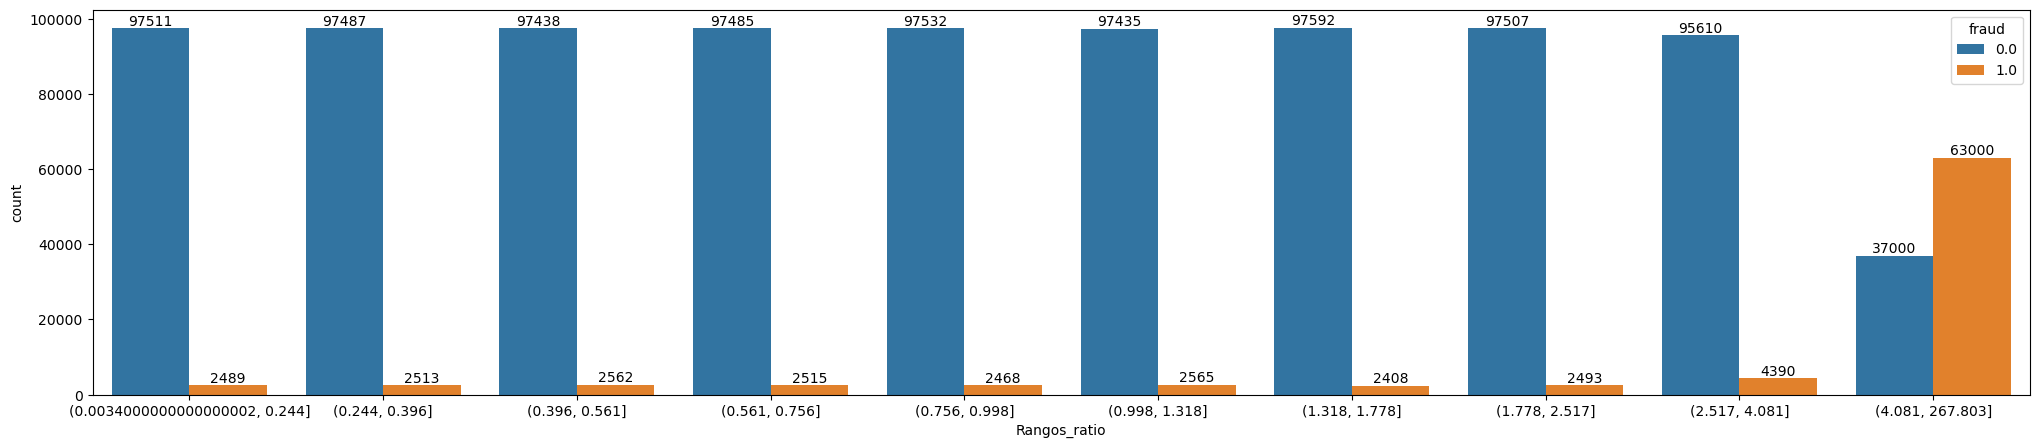

In [48]:
# Set the figure size
plt.figure(figsize=(25, 5))

# grouped barplot
ax = sb.countplot(x="Rangos_ratio", data=df_ratio, hue="fraud" )
for label in ax.containers:
    ax.bar_label(label)
plt.show()

In [ ]:
#Primer finding: De los 87,403 fraudes que hay, 63,000(el 72%) tienen un ratio mayor a 4.081